In [1]:
import os
import abc
from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

np.random.seed(int.from_bytes(os.urandom(4), byteorder="big"))

In [2]:
class PoissonProcess(abc.ABC):
    @abc.abstractmethod
    def generate(self, t: float) -> float:
        pass

    @abc.abstractmethod
    def generate_series(self, t: float) -> pd.Series:
        pass

In [3]:
class HomogenousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float):
        self.lambda_: float = lambda_

    def generate(self, t: float) -> float:
        u = np.random.uniform()
        t = t - 1 / self.lambda_ * np.log(u)
        return t

    def generate_series(self, t: float) -> pd.Series:
        t_ = 0
        s = []
        while True:
            t_ = self.generate(t_)
            if t_ > t:
                break
            s.append(t_)
        s = pd.Series(s)
        return s

In [4]:
class InhomogeneousPoissonProcess(PoissonProcess):
    def __init__(self, lambda_: float, lambda_t: Callable[[float], float]):
        self.lambda_: float = lambda_
        self.lambda_t: Callable[[float], float] = lambda_t

    def generate(self, t: float) -> float:
        while True:
            u1 = np.random.uniform()
            t = t - 1 / self.lambda_ * np.log(u1)
            u2 = np.random.uniform()
            if u2 <= self.lambda_t(t) / self.lambda_:
                return t

    def generate_series(self, t: float) -> pd.Series:
        t_ = 0
        s = []
        while True:
            t_ = self.generate(t_)
            if t_ > t:
                break
            s.append(t_)
        s = pd.Series(s)
        return s

In [32]:
@np.vectorize
def exp_prob(lambda_: float, start: float, end: float) -> float:
    return np.exp(-lambda_ * start) - np.exp(-lambda_ * end)

def chi2_exp(bins: np.ndarray, counts: np.ndarray) -> tuple[float, int, pd.DataFrame]:
    n = int(np.sum(counts))
    values = (bins[1:] + bins[:-1]) / 2
    x_b = np.sum(values * counts) / n
    lambda_s = 1 / x_b
    p = exp_prob(lambda_s, bins[:-1], bins[1:])
    ni = p * n
    delta_n = counts - ni
    delta_n2 = delta_n ** 2
    k = delta_n2 / ni
    table = pd.DataFrame({"i": values, "n_i": counts, "n'_i": ni, "n_i - n'_i": delta_n, "(n_i - n'_i)^2": delta_n2, "K": k}).set_index('i', drop=True)
    df = len(values) - 2
    return float(np.sum(k)), df, table

def chi2_test(pp: PoissonProcess, alpha: float, t: float):
    inc = pp.generate_series(t)
    display(inc)
    inc = inc.to_numpy()
    intervals = inc[1:] - inc[:-1]

    b = np.linspace(np.floor(intervals.min()), np.ceil(intervals.max()), int(1 + np.log2(len(intervals))))
    c, _ = np.histogram(intervals, bins=b)

    plt.stairs(c, b)

    chi2, df, t = chi2_exp(b.copy(), c.copy())

    chi2_crit = scipy.stats.chi2.isf(alpha, df=df, loc=0, scale=1)

    dft = pd.DataFrame.from_dict({
        "df": df,
        "chi2": chi2,
        "chi2_crit": chi2_crit,
        "H0": "принимаем" if chi2 < chi2_crit else "отвергаем"
    }, orient="index")
    display(dft)

In [33]:
T = 100
POISSON_LAMBDA = 2
POISSON_LAMBDA_T = lambda t: 1 + 1 / np.sqrt(t)
ALPHA = 0.05

In [34]:
hpp = HomogenousPoissonProcess(POISSON_LAMBDA)

0       0.384767
1       1.292787
2       1.847854
3       2.490376
4       3.515651
         ...    
172    97.119428
173    97.315324
174    98.089496
175    98.526341
176    98.809276
Length: 177, dtype: float64

,0
df,5
chi2,6.774672
chi2_crit,11.070498
H0,принимаем


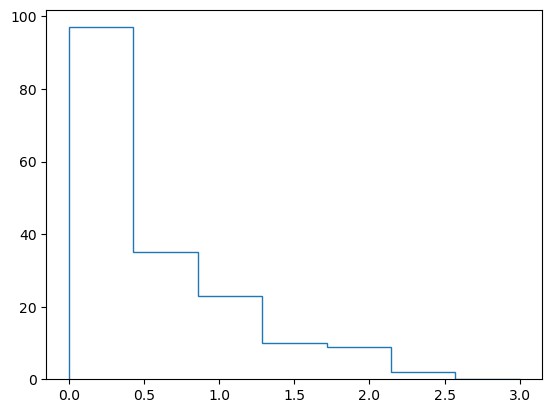

In [35]:
chi2_test(hpp, ALPHA, T)

In [15]:
ipp = InhomogeneousPoissonProcess(POISSON_LAMBDA, POISSON_LAMBDA_T)

In [22]:
ipp.generate_series(10)

0     0.473240
1     1.512422
2     2.724584
3     3.761417
4     4.403459
5     5.417829
6     6.471744
7     7.490457
8     9.148791
9     9.222852
10    9.357586
dtype: float64